# Data Science Capstone Project- SMS Spam Detection

## Background

Model for classification of SMS messages as genuine (ham) or spam using NLP. See blog post for more information.

The data was obtained from Kaggle using around 5500 SMS text messages. Around 13% of the messages were listed as spam and the remainder as ham. The data has just two columns, the text and the classification.

I utilised Stack Overflow and scikitlearn library as well as Towards Data Science to evaulate the model.

# Import libraries and load data

In [166]:
#import libraries
import matplotlib
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import sklearn as sklearn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot
from sklearn import tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline
    


%matplotlib inline
url1 = "https://raw.githubusercontent.com/docju/capstone2/main/spamraw.csv"
download1 = requests.get(url1).content


df = pd.read_csv(io.BytesIO(download1))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [167]:
#examine first ten rows
print(df.head(10))

   type                                               text
0   ham  Hope you are having a good week. Just checking in
1   ham                            K..give back my thanks.
2   ham        Am also doing in cbe only. But have to pay.
3  spam  complimentary 4 STAR Ibiza Holiday or £10,000 ...
4  spam  okmail: Dear Dave this is your final notice to...
5   ham  Aiya we discuss later lar... Pick u up at 4 is...
6   ham                             Are you this much buzy
7   ham                    Please ask mummy to call father
8  spam  Marvel Mobile Play the official Ultimate Spide...
9   ham     fyi I'm at usf now, swing by the room whenever


# Explore the data


In [168]:
#find number of rows and columns
df.shape

(5559, 2)

In [170]:
#find proportions of ham and spam
#this adds up to 5559 which confirms no missing values
df.type.value_counts()

ham     4812
spam     747
Name: type, dtype: int64

In [171]:
# Check for duplicates
#403 rows appear more than once
df[df.duplicated()].shape

(403, 2)

In [172]:
#Keep one instance of each message
df=df.drop_duplicates(['type','text'],keep='first')
print(df.shape)

(5156, 2)


In [173]:
df.type.value_counts()

ham     4503
spam     653
Name: type, dtype: int64

In [189]:
#no missing values in the text column
df['text'].isnull().sum()

0

# Clean the data

## Remove URL, email, phone, and currency

In [191]:
#source of url_regex from previous udacity project
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
#obtained from stack overflow
email_regex='^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})$'
phone_regex='[\+]?[0-9 ]{11,14}'
currency_regex='[\$|£|€][0-9\,]*\.?\d{2}'#'|[\$|£|€]+/-?\d+(,\d{3})*(\.\d{1,2})?$/'
# Write a function that performing basic cleaning on the text data by replacing links, phone numbers, email addresses and currency amounts
def clean_text(text):
    '''
    Cleans the text data by replacing URLs, @-replies, hashtags, and emoji with text placeholders.
    
    INPUT:
    text - (str) text data to be cleaned
    
    OUTPUT:
    text - (str) cleaned text data with placeholders
    ''' 
    #Replace phone numbers
    detected_phone = re.findall(phone_regex, text)
    #for i in range(0,len(detected_phone)):
    for phone in detected_phone:
           # if len(phone)>0:
        text = text.replace(phone, " phoneplaceholder ")
    # Replace money amounts
    
    #detected_currency=[]
    detected_currency = re.findall(currency_regex, text)
    for amount in detected_currency:
            text = text.replace(amount," cash_amount ")

    detected_email = re.findall(email_regex, text)
    for amount in detected_email:
        text = text.replace(amount," email_address ")
        
   
    
    return text

# Apply the text cleaning to our text column
df["clean_text"] = df["text"].apply(lambda x: clean_text(x))



In [192]:
#check how many of each have changed
#ham - 10 entries changed
print(df[(df['text']!=df['clean_text']) & (df['type']=='ham')].shape[0])
#spam- 434 entries changed
print(df[(df['text']!=df['clean_text']) & (df['type']=='spam')].shape[0])

10
434


In [193]:
# Drop the original text column and rename it back to text
sms= df.drop("text", axis=1)
sms = sms.rename(columns={"clean_text": "text", "type":"spam"})
sms.shape

(5156, 2)

In [194]:
#change the ham/spam flags to 1 and 0
sms.spam=sms.spam.replace({'ham':0,'spam':1})

sms.head(20)

,spam,text
0,0,Hope you are having a good week. Just checking in
1,0,K..give back my thanks.
2,0,Am also doing in cbe only. But have to pay.
3,1,complimentary 4 STAR Ibiza Holiday or cash_am...
4,1,okmail: Dear Dave this is your final notice to...
5,0,Aiya we discuss later lar... Pick u up at 4 is...
6,0,Are you this much buzy
7,0,Please ask mummy to call father
8,1,Marvel Mobile Play the official Ultimate Spide...
9,0,"fyi I'm at usf now, swing by the room whenever"


In [196]:
#volumes are unchanged
sms.spam.value_counts()

0    4503
1     653
Name: spam, dtype: int64

# Word Clouds for Ham and Spam SMS

We use Wordclouds to visualise how ham text might be different from spam texts- we look at the most common 100 words in each. From the visualisation, there does seem to be a difference between ham and spam, which looks like good news for our model later on!

In [197]:
#Normalize the data- keep only words and make lower case
sms['text_norm']=sms['text'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]", " ",x).lower())


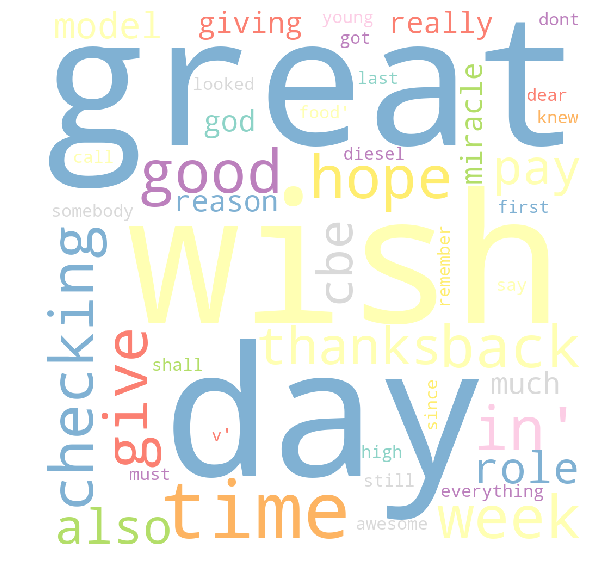

In [198]:
ham_words=sms[sms['spam']==0]['text_norm'].values
#Instantiate wordcloud object and use method to feed it our corpus

wc = WordCloud(  width=1000, 
    height=1000, 
    stopwords=stopwords.words("english"),
    min_font_size=8,
    max_words=100,
    background_color='white',
    colormap='Set3').generate_from_text(str(ham_words))


#Turn axis off to get rid of axis numbers
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation='nearest')
plt.axis('off')
plt.show()

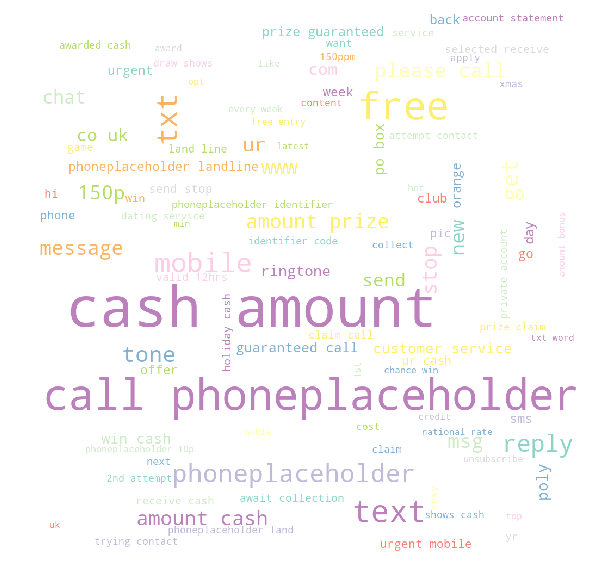

In [199]:
spam_words=sms[sms['spam']==1]['text_norm'].values
#Instantiate wordcloud object and use method to feed it our corpus
wc = WordCloud( width=1000, 
    height=1000, 
    stopwords=stopwords.words("english"),
    min_font_size=8,
    max_words=100,
    background_color='white',
    colormap='Set3').generate_from_text(str(spam_words))

#Use matplotlib.pyplot to display the fitted wordcloud
#Turn axis off to get rid of axis numbers
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation='nearest')
plt.axis('off')
plt.show()

The placeholders seem to be quite common in the spam texts- this may help us in the model later on.

# Data Pre-Processing

## Normalize and Tokenize the data

In [200]:
# We want to normalize the data to all lower case- 
#we also remove words in the stopwords list
def tokenize(text):
    #lower case
    text=text.lower()
    #keep only text and numericals
    text= re.sub(r"[^a-zA-Z0-9]", " ", text)
    tokens=word_tokenize(text)
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens if word not in stopwords.words("english")]
    return tokens



We can check the tokenization of the first few texts.

In [16]:
for i in range(0,10):
    print(tokenize(sms['text'][i]))

['hope', 'good', 'week', 'checking']
['k', 'give', 'back', 'thanks']
['also', 'cbe', 'pay']
['complimentary', '4', 'star', 'ibiza', 'holiday', 'cash', 'amount', 'cash', 'need', 'urgent', 'collection', 'phoneplaceholder', 'landline', 'lose', 'box434sk38wp150ppm18']
['okmail', 'dear', 'dave', 'final', 'notice', 'collect', '4', 'tenerife', 'holiday', '5000', 'cash', 'award', 'call', 'phoneplaceholder', 'landline', 'tc', 'sae', 'box326', 'cw25wx', '150ppm']
['aiya', 'discus', 'later', 'lar', 'pick', 'u', '4']
['much', 'buzy']
['please', 'ask', 'mummy', 'call', 'father']
['marvel', 'mobile', 'play', 'official', 'ultimate', 'spider', 'man', 'game', 'cash', 'amount', 'ur', 'mobile', 'right', 'text', 'spider', '83338', 'game', 'send', 'u', 'free', '8ball', 'wallpaper']
['fyi', 'usf', 'swing', 'room', 'whenever']


# Feature Engineering

Here, we create some new features, 1-0 flag, a count, or a float.

We include whether or not the original text was in all caps, the number of words in the text, the number of latin letters, and the proportion of the text that was latin letters.

# New text-based features

In [225]:
#denotes if the sms was entirely in upper case
def upper_flag(text):
    '''
    Uses a 1-0 flag to indicate whether the original text of the SMS was all in upper case    
    INPUT:
    text - (str) text data to look at 
    
    OUTPUT:
    upper_case_flag- 1-0 flag
    ''' 
    text_upper=re.sub(r"[^a-zA-Z]", "",text.upper())
    upper_case_flag=0
    if text_upper==re.sub(r"[^a-zA-Z]", "",text) and len(text_upper)>0:
        upper_case_flag=1
    return upper_case_flag

#count the number of words
def num_of_words(text):
    '''
    Counts the number of words in the SMS   
    INPUT:
    text - (str) text data to look at 
    
    OUTPUT:
    number of words (float)
    ''' 
    words=text.split()
    word_count=len(words)
    return word_count

#count the number of alphabet characters

def num_of_alphabet(text):
    '''
    Counts the number of latin alphabet characters in the SMS   
    INPUT:
    text - (str) text data to look at 
    
    OUTPUT:
    number of characters (float)
    ''' 
    text_alpha_only=re.sub(r"[^a-zA-Z]", "",text)
    return len(text_alpha_only)

#number of alphabet characters as a proportion of length of text
def prop_of_alphabet(text):
    '''
    Counts the proportion of latin alphabet characters in the SMS   
    INPUT:
    text - (str) text data to look at 
    
    OUTPUT:
    proportion of characters (float)
    ''' 
    text_alpha_only=re.sub(r"[^a-zA-Z]", "",text)
    return len(text_alpha_only)/len(text)

In [226]:
#quick spot check
num_of_alphabet(sms.text.iloc[450])

111

In [227]:
#create class function to do all these counts at once
class smscounter(BaseEstimator,TransformerMixin):
    def sms_count(self,text):
        up_case=upper_flag(text)
        num_words=num_of_words(text)
        num_alpha_char=num_of_alphabet(text)
        prop_alpha_char=prop_of_alphabet(text)
            
        features = pd.Series({"up_case": up_case, 
                              "num_of_words": num_words, 
                              "num_alpha_char": num_alpha_char, 
                              "prop_alpha_char": prop_alpha_char
                                  })
        return features
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_counts = pd.Series(X).apply(self.sms_count)
        return X_counts.astype(float)

In [206]:
#test it out
sms_counts=smscounter()

test_transformed = sms_counts.fit_transform(sms['text'])

In [21]:
test_transformed.head()

,up_case,num_of_words,num_alpha_char,prop_alpha_char
0,0.0,10.0,39.0,0.795918
1,0.0,4.0,17.0,0.739130
2,0.0,10.0,32.0,0.744186
3,0.0,21.0,123.0,0.768750
4,0.0,27.0,122.0,0.734940


In [208]:
#this and follow cells show distribution
test_transformed.up_case.value_counts()

0.0    5066
1.0      90
Name: up_case, dtype: int64

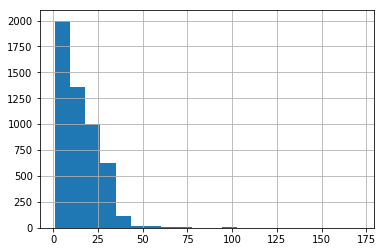

In [211]:
test_transformed['num_of_words'].hist(bins=20)

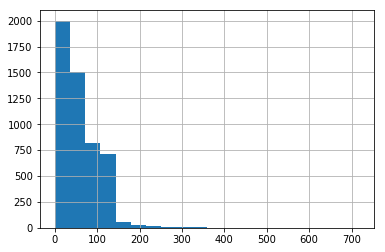

In [212]:
test_transformed['num_alpha_char'].hist(bins=20)

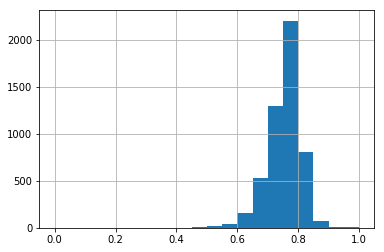

In [213]:
test_transformed['prop_alpha_char'].hist(bins=20)

# Modelling

We look at one model type first with a Random Forest Classifier with default parameters, then we check other classifiers before finally using grid search to test the hyperparameters.

We will use accuracy, precision, recall and F1-score to evaluate the models, each of which will use the same training and test data sets.

## Split into train and test sets

In [215]:
X=sms['text']
Y=sms['spam']

In [218]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=23)
#Ensure proportions are roughly similar
print(Y_train.value_counts())
print(Y_test.value_counts())

0    3382
1     485
Name: spam, dtype: int64
0    1121
1     168
Name: spam, dtype: int64


In [220]:
#intialise the pipeline
pipeline=Pipeline([
    ('features',FeatureUnion([
        ('text_pipeline',Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer())
        ])),
        ('sms_counts',smscounter())
    ])),
    ('clf',RandomForestClassifier())
])

In [221]:
pipeline.fit(X_train,Y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [222]:
# Make predictions using the trained model
Y_pred = pipeline.predict(X_test)

In [229]:
# create function to display the results
def display_results(y_test,y_pred):
    '''
    Displays the accuracy and confusion matrix of the model test   
    INPUT:
    y_test, y_pred- test outcome data and prediction outcome data 
    
    OUTPUT:
    confusion matrix and accuracy (printout)
    ''' 
    labels=np.unique(y_pred)
    confusion_mat=confusion_matrix(y_test,y_pred,labels=labels)
    accuracy=(y_pred==y_test).mean()
    print("labels",labels)
    print("Confusion Matrix: \n",confusion_mat)
    print("Accuracy:",accuracy)

In [230]:
display_results(Y_test,Y_pred)

labels [0 1]
Confusion Matrix: 
 [[1121    0]
 [  37  131]]
Accuracy: 0.971295577967


97% accuracy is excellent as a start, but we may want to improve as any spam SMS is annoying.

In [233]:
#see how this accuracy compares to the training set
Y_pred_train=pipeline.predict(X_train)

In [232]:
display_results(Y_pred_train,Y_train)

labels [0 1]
Confusion Matrix: 
 [[3382    7]
 [   0  478]]
Accuracy: 0.998189811223


Almost 100% accuracy on training dataset which is expected

In [234]:
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.97      1.00      0.98      1121
          1       1.00      0.78      0.88       168

avg / total       0.97      0.97      0.97      1289



These outcomes are pretty good, but we have work to do on the recall. Let's try some other classifiers and see how they compare. First, we create a function to allow us to compare classifiers easily.

In [235]:
def new_classifier(classifier):
    '''
    Runs and evaulates the model with the specified classifier
    INPUT:
    classifier type, X, Y 
    
    OUTPUT:
    confusion matrix and accuracy (printout)
    ''' 
    pipeline=Pipeline([
    ('features',FeatureUnion([
        ('text_pipeline',Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer())
        ])),
                ('sms_counts',smscounter())
                            ])),
                ('clf',classifier)
                        ])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=23)
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    
    display_results(Y_test,Y_pred)
    print(classification_report(Y_test, Y_pred))
    return pipeline

## Decision Tree

In [236]:
new_classifier(DecisionTreeClassifier())

labels [0 1]
Confusion Matrix: 
 [[1113    8]
 [  29  139]]
Accuracy: 0.971295577967
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1121
          1       0.95      0.83      0.88       168

avg / total       0.97      0.97      0.97      1289



Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

## Logistic Regression 

In [238]:
new_classifier(LogisticRegression())

labels [0 1]
Confusion Matrix: 
 [[1116    5]
 [  42  126]]
Accuracy: 0.963537626067
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1121
          1       0.96      0.75      0.84       168

avg / total       0.96      0.96      0.96      1289



Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## k Nearest Neighbors 

In [240]:
new_classifier(KNeighborsClassifier())

labels [0 1]
Confusion Matrix: 
 [[1071   50]
 [  63  105]]
Accuracy: 0.912335143522
             precision    recall  f1-score   support

          0       0.94      0.96      0.95      1121
          1       0.68      0.62      0.65       168

avg / total       0.91      0.91      0.91      1289



Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

Using all these, it looks like the Decision Tree model is the best choice, considering all metrics.

## Tuning model with GridSearch and Hyperparameters 

In the next steps, we determine what parameters we can tune and run a selection of them through Grid Search to tune the model further- as stated above, we use the decision tree classifier as it appeared to perform best.

In [45]:
pipeline_tree=Pipeline([
    ('features',FeatureUnion([
        ('text_pipeline',Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer())
        ])),
        ('sms_counts',smscounter())
    ])),
    ('clf',DecisionTreeClassifier())
])

In [241]:
#get parameter list
pipeline_tree.get_params()

{'memory': None, 'steps': [('features', FeatureUnion(n_jobs=1,
          transformer_list=[('text_pipeline', Pipeline(memory=None,
        steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip...y=None)), ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))])), ('sms_counts', smscounter())],
          transformer_weights=None)),
  ('clf',
   DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
               splitter='be

In [65]:
#choose parameters to put into gridsearch
parameters= {
    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
    'features__text_pipeline__vect__min_df': [1, 5],
    'features__text_pipeline__tfidf__use_idf':(True,False),
    'clf__min_samples_leaf':(1,10)
}



In [66]:
cv=GridSearchCV(pipeline_tree,param_grid=parameters,n_jobs=-1,cv=2)
cv.fit(X_train,Y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)), 'features__text_pipeline__vect__min_df': [1, 5], 'features__text_pipeline__tfidf__use_idf': (True, False), 'clf__min_samples_leaf': (1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [69]:
# best parameters chosen
cv.best_params_




{'clf__min_samples_leaf': 1,
 'features__text_pipeline__tfidf__use_idf': False,
 'features__text_pipeline__vect__min_df': 5,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

In [70]:
#score of the best-functioning model
cv.best_score_

0.97181277476079653

In [68]:
#show accuracy etc
y_pred_cv=cv.predict(X_test)

display_results(Y_test,y_pred_cv)
print(classification_report(Y_test, y_pred_cv))

labels [0 1]
Confusion Matrix: 
 [[1114    7]
 [  22  146]]
Accuracy: 0.977501939488
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1121
          1       0.95      0.87      0.91       168

avg / total       0.98      0.98      0.98      1289



# Evaluation: Area under curve (AUC) and ROC  

We have excellent scores for nearly all metrics having altered the parameters using Grid Search so now we look at overall model performance by AUC and plotting the ROC curve.

In [75]:
cv_probs=cv.predict_proba(X_test)

pos_probs=cv_probs[:,1]

# Calculate AUC score
auc = roc_auc_score(Y_test, pos_probs)

print(auc)

0.931401597213


A good score!

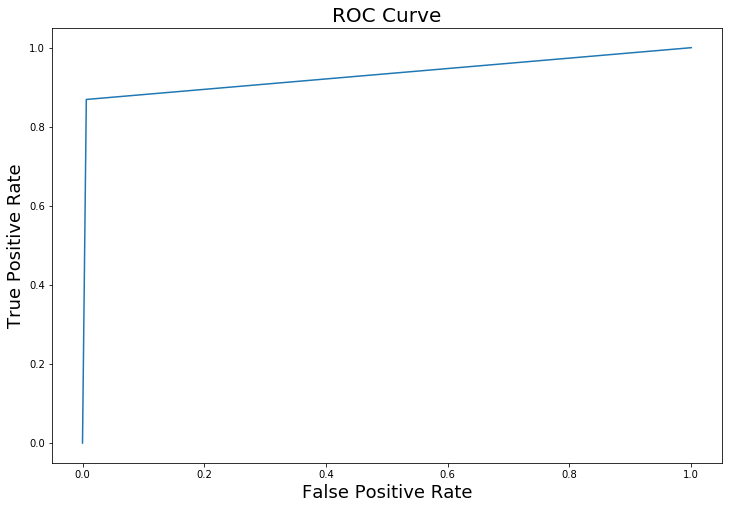

In [78]:
fpr, tpr, thresholds = roc_curve(Y_test, pos_probs, pos_label=1)

fig, ax = plt.subplots(1, 1, figsize=[12,8])
plt.plot(fpr, tpr)
ax.set_title("ROC Curve", fontsize=20)
ax.set_xlabel("False Positive Rate", fontsize=18)
ax.set_ylabel("True Positive Rate", fontsize=18)
plt.show()

The ROC plot is a curve at a sharp angle, meaning that the volume of false positives is low and the classification is excellent at determining spam/ham.

# Future Work

We could analyse which features contributed most to the model- given the changes in the placholders affecting a large volume of spam calls but a small volume of ham, it is likely that these features will be the most important- the version of scikitlearn installed in this workspace did not have the necessary tools to check this so a future version would help.

In [133]:
len(cv.named_steps['clf'].tree_.compute_feature_importances(normalize=False))

1579